In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/submit.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/framebuffer.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/replay_buffer.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Selecting previously unselected package xvfb.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [ ]:
%tensorflow_version 1.x

In [ ]:
import tensorflow

In [ ]:
print(tensorflow.__version__)

1.15.2


In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Processing game image 

Raw Atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [ ]:
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

###ObservationWrapper 
ObservationWrapper is a class and inheriting from this class allows to create class that has method called observation that overrides the observation() in ObservationWrapper and this function returns observation. So, we can customize the observation or state returned by environment using this class as a parent class.

In [ ]:
from gym.core import ObservationWrapper
from gym.spaces import Box

import cv2


class PreprocessAtari(ObservationWrapper):#this class inherits from observationwrapper
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1)) #Box() is creating continuous observation space from 0.0 to 1.0 with shape of (img_size[0], img_size[1], 1)

    def observation(self, img):
      """what happens to each observation"""

      # Here's what you need to do:
      #  * Crop image, remove irrelevant parts.
      #  * Resize image to self.img_size. Use cv2.resize or any other library you want,
      #    e.g. PIL or Keras. Do not use skimage.transform.resize because it is roughly
      #    6x slower than cv2.resize.
      #  * Cast image to grayscale.
      #  * Convert image pixels to (0, 1) range, float32 type.

      #  Crop image
      img = img[34:-16, :, :]

      #  Resize image
      img = cv2.resize(img, self.img_size)

      #  Gray scale
      img = img.mean(-1, keepdims=True)

      #  Normalize
      img = img.astype('float32')/255.
      return img

In [ ]:
import gym

In [ ]:
env = gym.make("BreakoutDeterministic-v0")
env = PreprocessAtari(env)

In [ ]:
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
obs = env.reset()

###Test observation

In [ ]:
assert obs.ndim == 3, "observation must be [height, width, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <= 1, "convert image pixels to (0,1) range"
assert np.max(obs) >= 0.5, "It would be easier to see a brighter observation"
assert np.mean(obs) >= 0.1, "It would be easier to see a brighter observation"

Formal tests seem fine. Here's an example of what you'll get.


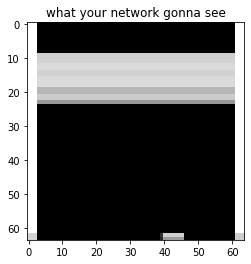

In [ ]:
print("Formal tests seem fine. Here's an example of what you'll get.")
plt.title("what your network gonna see")
plt.imshow(obs[:, :, 0], interpolation='none', cmap='gray')

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [ ]:
from framebuffer import FrameBuffer

###FrameBuffer
Wraps the environment to allow a modular transformation.

This class is the base class for all wrappers. The subclass could override
some methods to change the behavior of the original environment without touching the
original code.

In [ ]:
def make_env():
  env = gym.make("BreakoutNoFrameskip-v4")
  env = PreprocessAtari(env)
  env = FrameBuffer(env,n_frames = 4, dim_order='tensorflow')
  return env


In [ ]:
env = make_env()
env.reset()
n_actions = env.action_space.n
obs_state_dim = env.observation_space.shape

😌 env.render("rgb_array") returns image in the form of tensor and plt.imshow() plots the image when image is passed in the form tensor as the argument.

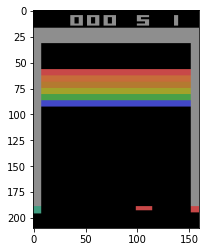

In [ ]:
plt.imshow(env.render("rgb_array"))

In [ ]:
for _ in range(50):
  obs, _, _, _ = env.step(env.action_space.sample())

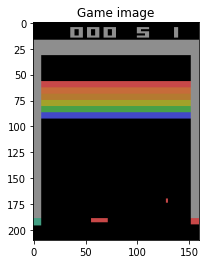

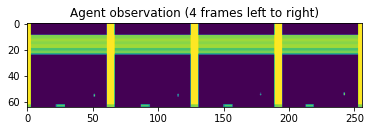

In [ ]:
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([obs_state_dim[0], -1]))

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

In [ ]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

❓ What is with TF Variable_scope?

tf.variable_scope(name_or_scope, reuse=None, initializer=None) Returns a context for variable scope. Variable scope allows to create new variables and to share already created ones while providing checks to not create or share by accident.

🔗https://stackoverflow.com/questions/35919020/whats-the-difference-of-name-scope-and-a-variable-scope-in-tensorflow

In [ ]:
from keras.layers import Conv2D, Dense, Flatten, InputLayer
import keras

Using TensorFlow backend.


In [ ]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            # < Define your network body here. Please make sure you don't use any layers created elsewhere >
            self.network = keras.models.Sequential()
    
            # Keras ignores the first dimension in the input_shape, which is the batch size. 
            # So just use state_shape for the input shape
            self.network.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
            self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.network.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.network.add(Flatten())
            self.network.add(Dense(256, activation='relu'))
            self.network.add(Dense(n_actions, activation='linear'))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        
        qvalues = self.network(state_t)
        
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [ ]:
agent = DQNAgent("dqn_agent", obs_state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [ ]:
evaluate(env, agent, n_games=1)

4.0

### Experience replay

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

In [ ]:
import random
from collections import deque

In [ ]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = deque([])
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage.append(data)

        # add data to storage
        if(self.__len__() > self._maxsize):
          self._storage.popleft()

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        #indxes = <YOUR CODE: randomly generate batch_size integers to be used as indexes of samples>
        trajectory_numbers = [np.random.choice(range(self.__len__())) for t in range(batch_size)]

        # collect <s,a,r,s',done> for each index
        obs_batch = []
        action_batch = []
        reward_batch = []
        next_obs_batch = []
        done_batch = []

        for i in trajectory_numbers:
          obs_batch.append(self._storage[i][0])#storage is a list of tuples, each tuple being(s,a,r,s',done).Each tuple is a trajectory and storage is a collection of sequential trajectories
          action_batch.append(self._storage[i][1])
          reward_batch.append(self._storage[i][2])
          next_obs_batch.append(self._storage[i][3])
          done_batch.append(self._storage[i][4])

        return (
            np.array( obs_batch ),
            np.array( action_batch ),
            np.array( reward_batch ),
            np.array( next_obs_batch ),
            np.array( done_batch),
        )

In [ ]:
#make object of type ReplayBuffer
exp_replay = ReplayBuffer(10)#max size of buffer is 10

for _ in range(30):#sample 30 trajectories
  exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)#We are randomly adding obs_states and next_obs_states using env.reset()

obs_batch, action_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)#batch size is 5 i.e each batch has information of 5 trajectories randomly sampled from buffer

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [ ]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time
    """
    # initial state
    s = env.framebuffer

    # Play the game for n_steps as per instructions above
    reward = 0.0
    for t in range(n_steps):#n_steps are time steps
      # get agent to pick action given state s
      qvalues = agent.get_qvalues([s])
      action = agent.sample_actions(qvalues)[0]
      
      next_s, r, done, _ = env.step(action)


      #add to replay buffer
      exp_replay.add(s, action, r, next_s, done)

      reward += r
      if done:
        s = env.reset()

      else:
        s = next_s
    return reward

In [ ]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 10000, (
    "play_and_record should have added exactly 10000 steps, " +
    "but instead added %i") % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, (
    "Please make sure you restart the game whenever it is 'done' " +
    "and record the is_done correctly into the buffer." +
    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"
) % (np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + obs_state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"

print("Well done!")

Well done!


###### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)



In [ ]:
target_network = DQNAgent("target_network", obs_state_dim, n_actions)#first parameter defines the name of the variable scope for DQNAgent

😌 tf.assign(ref, value, validate_shape)

ref is a variable tensor, value is a tensor which is to be assigned to the ref tensor. validate_shape is a bool which if true he operation will validate that the shape of 'value' matches the shape of the Tensor being assigned to. If false, 'ref' will take on the shape of 'value'.

It returns A Tensor that will hold the new value of 'ref' after the assignment has completed.


In [ ]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    # tf.get_default_session().run(assigns)
    return assigns

😌zip(*iterables) --> zip object

Return a zip object whose . __next__() method returns a tuple where
the i-th element comes from the i-th iterable argument.  The .__next__()
method continues until the shortest iterable in the argument sequence
is exhausted and then it raises StopIteration.

😌def run(fetches, feed_dict = None)

Runs operations and evaluates tensors in fetches.


The optional feed_dict argument allows the caller to override
the value of tensors in the graph. Each key in feed_dict can be
a tf.Tensor or tf.SparseTensor .

In [ ]:
# create the tf copy graph only once.
copy_step = load_weights_into_target_network(agent, target_network)
sess.run(copy_step)

In [ ]:
# check that it works
sess.run([tf.assert_equal(w,w_target) for w,w_target in zip(agent.weights, target_network.weights)])
print("It works!")

It works!


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

😌def placeholder(dtype, shape=None, name=None)

Inserts a placeholder for a tensor that will be always fed.

In [ ]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + obs_state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + obs_state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

In [ ]:
is_not_done = 1 - is_done_ph
gamma = 0.99

In [ ]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)#takes agent's observation, returns qvalues. Both are tf Tensors
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis = 1)

In [ ]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)#get_symbolic_qvalues() acts as predict() as such outputs tensor of action values for a given state and for all actions
next_state_values_target = tf.reduce_max(next_qvalues_target)
reference_qvalues = rewards_ph + gamma * next_state_values_target*is_not_done

# Define loss function for sgd
td_loss = (current_action_qvalues - reference_qvalues)**2#here td_loss is a tensor
td_loss = tf.reduce_mean(td_loss)#here mean td_loss obtained from td_loss tensor

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list = agent.weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


😌 def global_variables_initializer()

Returns an Op that initializes global variables in the graph.

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = "Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! "
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

assert tf.gradients(reference_qvalues, is_not_done)[0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[0] is None, "reference qvalues shouldn't depend on current observation!"  # ignore if you're certain it's ok
print("Splendid!")

Splendid!


### Main loop

It's time to put everything together and see if it learns anything.

In [ ]:
from tqdm import trange
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
mean_rw_history = []
td_loss_history = []

In [ ]:
def moving_average(x, span=100, **kw):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values

In [ ]:
exp_replay = ReplayBuffer(10**5)#maximum size of buffer = 50
play_and_record(agent, env, exp_replay, n_steps = 10000)

def sample_batch(exp_replay, batch_size):
  obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
  return
  {
      obs_ph:obs_batch, action_ph:act_batch, rewards_ph:reward_batch,
      next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
  }

In [ ]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)


def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph: obs_batch,
        actions_ph: act_batch,
        rewards_ph: reward_batch,
        next_obs_ph: next_obs_batch,
        is_done_ph: is_done_batch,
    }

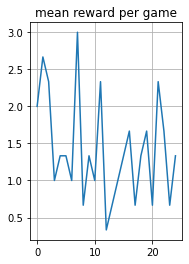

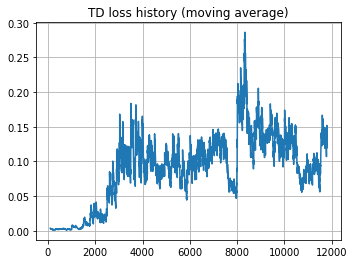

 12%|█▏        | 11802/100000 [2:30:00<24:55:52,  1.02s/it]

In [ ]:
for i in trange(10**5):
    # play
    play_and_record(agent, env, exp_replay, 10)

    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)

    # adjust agent parameters
    if i % 500 == 0:
        # You could think that loading weights onto a target network is simply
        #     load_weigths_into_target_network(agent, target_network)
        # but actually calling this function repeatedly creates a TF copy operator
        # again and again, which bloats memory consumption with each training step.
        # Instead, you should create 'copy_step' once.
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))

    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.subplot(1, 2, 1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()